# Flow Dashboard

Display visualizations from Github data.


## Setup

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Date tools
from datetime import date
from dateutil.relativedelta import relativedelta, SU

# Prep Plots

# Bigger text
plt.rc('font', size=12)


def plotPie(df, title, xLabel):
    def label_point(pct, allvals):
        absolute = int(np.round(pct/100.*np.sum(allvals)))
        return "{:.1f}%\n({:d})".format(pct, absolute)

    print()
    plt.figure(figsize=(10, 5))
    plt.title(title, fontsize=20)
    df.sum().plot(kind='pie', legend=False,
                  autopct=lambda pct: label_point(pct, df.sum()),
                  pctdistance=1.16, labeldistance=.4)
    plt.ylabel(None)  # Clear yLabel
    plt.xlabel(xLabel, fontsize=16)
    plt.show()

# Date utils


def get_previous_sunday(working_date=date.today()):
    last_sunday = working_date + relativedelta(weekday=SU(-1))
    return last_sunday.strftime("%Y-%m-%d")

# Plot utils


def plot_line(df, title, xlabel, ylabel, lines):
    plt.figure(figsize=(20, 10), facecolor='white')
    plt.title(title, fontsize=20)
    for l in lines:
        df[l['col']].plot(color=l['color'], label=l['label'],
                          legend=True).set_ybound(0)

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()


def plot_bar(df, title, xlabel, ylabel, lines):
    plt.figure(figsize=(20, 10), facecolor='white')
    plt.title(title, fontsize=20)
    for l in lines:
        df[l['col']].plot(kind='bar', color=l['color'], legend=True)

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()


# DF utils

def pivot_with_zeros(df, index, columns, values):
    df = df.pivot(index, columns, values)

    # Replace NaN
    df = df.fillna(0)

    return df


In [2]:
# Read PRs
prs = pd.read_csv('prs_data.csv', parse_dates=[
                  'closedAt', 'createdAt', 'updatedAt']).set_index('number')

prs


,title,author,assignees,url,state,closedAt,createdAt,updatedAt,labels,issues,hoursFromOpen,hoursToClose
number,,,,,,,,,,,,
2078,2060 update q2 page,gonzalovelasco,{'gonzalovelasco'},https://github.com/weiks/esports-backend/pull/...,OPEN,NaT,2022-08-30 18:31:03+00:00,2022-08-30 19:18:05+00:00,"{'critical', 'cleanup'}","[{'assignees': {'gonzalovelasco'}, 'labels': {...",1.300313,NaN
2070,Retro doc,bmcilw1,{'bmcilw1'},https://github.com/weiks/esports-backend/pull/...,OPEN,NaT,2022-08-29 16:04:00+00:00,2022-08-30 19:10:04+00:00,{'docs'},[],27.751147,NaN
2065,Add retro issue template,bmcilw1,{'bmcilw1'},https://github.com/weiks/esports-backend/pull/...,OPEN,NaT,2022-08-26 21:47:02+00:00,2022-08-30 19:09:49+00:00,{'docs'},[],94.033925,NaN
2062,Add bug template,weiks,"{'weiks', 'bmcilw1'}",https://github.com/weiks/esports-backend/pull/...,OPEN,NaT,2022-08-26 20:20:52+00:00,2022-08-30 19:09:45+00:00,{'docs'},[],95.470036,NaN
2063,Add feature request template,weiks,"{'weiks', 'bmcilw1'}",https://github.com/weiks/esports-backend/pull/...,OPEN,NaT,2022-08-26 20:27:34+00:00,2022-08-30 19:09:39+00:00,{'docs'},[],95.358369,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
6,Add auth middleware to discord/token endpoint,Mathspy,{'Mathspy'},https://github.com/weiks/esports-backend/pull/6,MERGED,2020-03-18 01:17:28+00:00,2020-03-18 01:16:02+00:00,2020-03-18 01:17:34+00:00,set(),[],21498.550664,0.023889
5,Add users to db on successful OAuth,Mathspy,{'Mathspy'},https://github.com/weiks/esports-backend/pull/5,MERGED,2020-03-17 22:39:52+00:00,2020-03-17 22:33:44+00:00,2020-03-17 22:39:55+00:00,set(),[],21501.255664,0.102222
4,Swapped REDIRECT_URI to be env var based,Mathspy,{'Mathspy'},https://github.com/weiks/esports-backend/pull/4,MERGED,2020-03-14 21:08:57+00:00,2020-03-14 21:00:49+00:00,2020-03-14 21:09:00+00:00,set(),[],21574.804275,0.135556


In [3]:
# Read Issues
issues = pd.read_csv('issues_data.csv', parse_dates=[
    'closedAt', 'createdAt', 'updatedAt']).set_index('number')

issues


,title,author,assignees,url,state,closedAt,createdAt,updatedAt,labels,daysFromOpen,daysToClose
number,,,,,,,,,,,
2077,[Retro] CI is taking too long to run,brianmazzocchi,set(),https://github.com/weiks/esports-backend/issue...,OPEN,NaT,2022-08-30 18:03:29+00:00,2022-08-30 19:04:42+00:00,{'retro'},0.073833,NaN
2027,All qBot user-facing commands,Mathspy,set(),https://github.com/weiks/esports-backend/issue...,OPEN,NaT,2022-08-23 16:05:00+00:00,2022-08-30 18:47:17+00:00,set(),7.156113,NaN
2068,[Retro] PRs review delay,CarlosViller,set(),https://github.com/weiks/esports-backend/issue...,OPEN,NaT,2022-08-29 13:51:28+00:00,2022-08-30 18:41:30+00:00,{'retro'},1.248845,NaN
2060,Buy Q2 Page Copy and logo update,wildkara,{'gonzalovelasco'},https://github.com/weiks/esports-backend/issue...,OPEN,NaT,2022-08-26 19:38:42+00:00,2022-08-30 18:32:22+00:00,"{'critical', 'cleanup'}",4.007711,NaN
2057,[Frontend] Buy Quarters Copy updates,wildkara,{'gonzalovelasco'},https://github.com/weiks/esports-backend/issue...,CLOSED,2022-08-30 16:58:29+00:00,2022-08-26 15:17:36+00:00,2022-08-30 16:58:29+00:00,"{'critical', 'cleanup'}",4.189030,4.070058
...,...,...,...,...,...,...,...,...,...,...,...
527,[Airbrake] [Production] 10 ABORTED: The refere...,weiks,{'Mathspy'},https://github.com/weiks/esports-backend/issue...,CLOSED,2021-03-31 14:43:40+00:00,2021-03-11 08:16:28+00:00,2021-03-31 14:43:40+00:00,set(),537.481484,20.268889
392,[Airbrake] [Production] Cannot read property '...,weiks,set(),https://github.com/weiks/esports-backend/issue...,CLOSED,2021-01-23 20:47:12+00:00,2021-01-23 17:12:17+00:00,2021-01-23 20:47:12+00:00,set(),584.109390,0.149248
391,"[Airbrake] [Production] Value for argument ""do...",weiks,set(),https://github.com/weiks/esports-backend/issue...,CLOSED,2021-01-23 20:38:37+00:00,2021-01-23 16:48:08+00:00,2021-01-23 20:38:37+00:00,set(),584.126160,0.160058


## Work In Progress (WIP)

In [4]:
open_prs = prs[prs["state"] == 'OPEN'].sort_values(by='hoursFromOpen', ascending=False)

open_prs


,title,author,assignees,url,state,closedAt,createdAt,updatedAt,labels,issues,hoursFromOpen,hoursToClose
number,,,,,,,,,,,,
2062,Add bug template,weiks,"{'weiks', 'bmcilw1'}",https://github.com/weiks/esports-backend/pull/...,OPEN,NaT,2022-08-26 20:20:52+00:00,2022-08-30 19:09:45+00:00,{'docs'},[],95.470036,NaN
2063,Add feature request template,weiks,"{'weiks', 'bmcilw1'}",https://github.com/weiks/esports-backend/pull/...,OPEN,NaT,2022-08-26 20:27:34+00:00,2022-08-30 19:09:39+00:00,{'docs'},[],95.358369,NaN
2065,Add retro issue template,bmcilw1,{'bmcilw1'},https://github.com/weiks/esports-backend/pull/...,OPEN,NaT,2022-08-26 21:47:02+00:00,2022-08-30 19:09:49+00:00,{'docs'},[],94.033925,NaN
2070,Retro doc,bmcilw1,{'bmcilw1'},https://github.com/weiks/esports-backend/pull/...,OPEN,NaT,2022-08-29 16:04:00+00:00,2022-08-30 19:10:04+00:00,{'docs'},[],27.751147,NaN
2076,Misc generator improvements,Mathspy,{'Mathspy'},https://github.com/weiks/esports-backend/pull/...,OPEN,NaT,2022-08-30 16:13:08+00:00,2022-08-30 16:20:12+00:00,set(),[],3.598925,NaN
2078,2060 update q2 page,gonzalovelasco,{'gonzalovelasco'},https://github.com/weiks/esports-backend/pull/...,OPEN,NaT,2022-08-30 18:31:03+00:00,2022-08-30 19:18:05+00:00,"{'critical', 'cleanup'}","[{'assignees': {'gonzalovelasco'}, 'labels': {...",1.300313,NaN


## PRs Over Time

### Total PRs Over Time

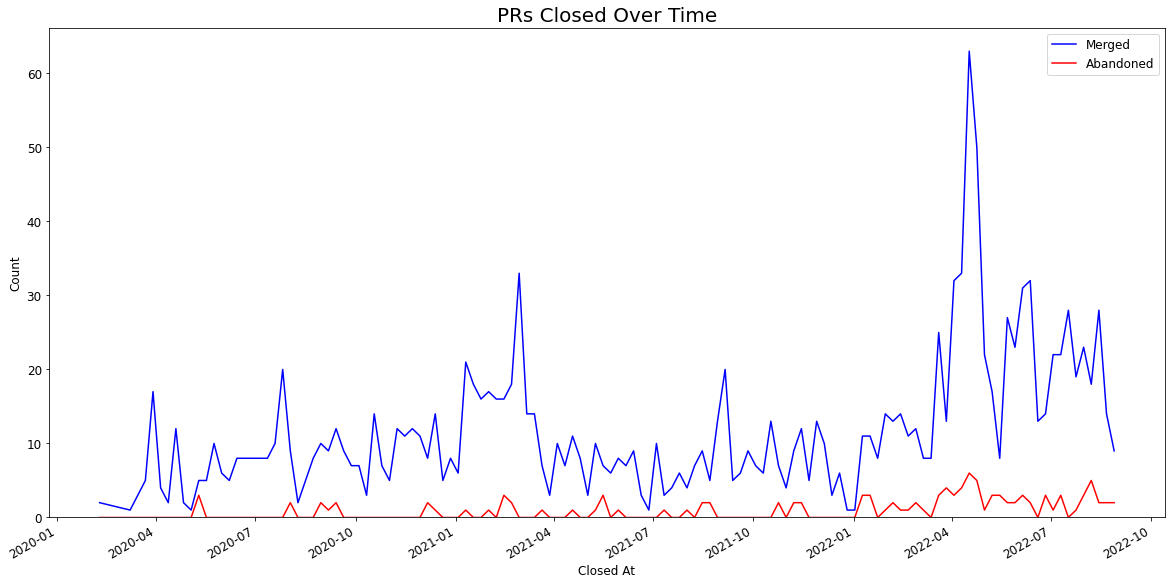

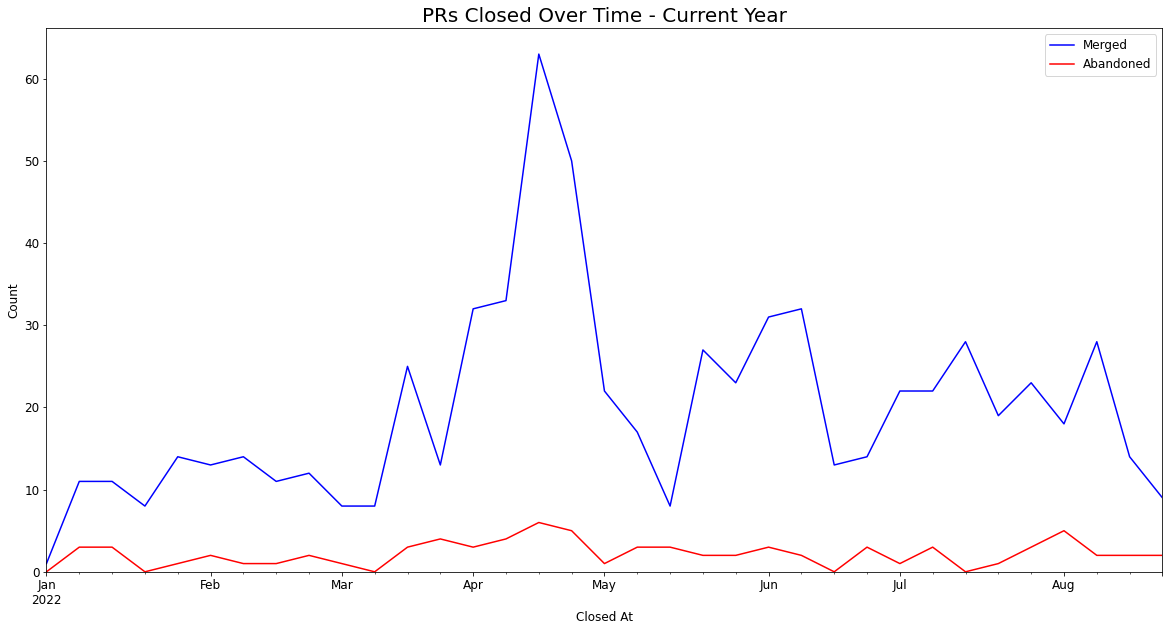

In [5]:
# Count CLOSED/MERGED items per week
weekly_prs = prs.set_index('closedAt').groupby(
    [pd.Grouper(freq='W', label='left'), pd.Grouper('state')])['state'].count().reset_index(name='count')

weekly_prs_pivot = pivot_with_zeros(weekly_prs, 'closedAt', 'state', 'count')

plot_line(weekly_prs_pivot, 'PRs Closed Over Time', 'Closed At', 'Count', [
          {'col': 'MERGED', 'color': 'blue', 'label': 'Merged'}, {'col': 'CLOSED', 'color': 'red', 'label': 'Abandoned'}])

# Filter to current year
weekly_prs_year = weekly_prs[weekly_prs['closedAt'].dt.year == date.today(
).year]

weekly_prs_pivot_year = pivot_with_zeros(
    weekly_prs_year, 'closedAt', 'state', 'count')

plot_line(weekly_prs_pivot_year, 'PRs Closed Over Time - Current Year', 'Closed At', 'Count', [
          {'col': 'MERGED', 'color': 'blue', 'label': 'Merged'}, {'col': 'CLOSED', 'color': 'red', 'label': 'Abandoned'}])


### Average Duration of PRs

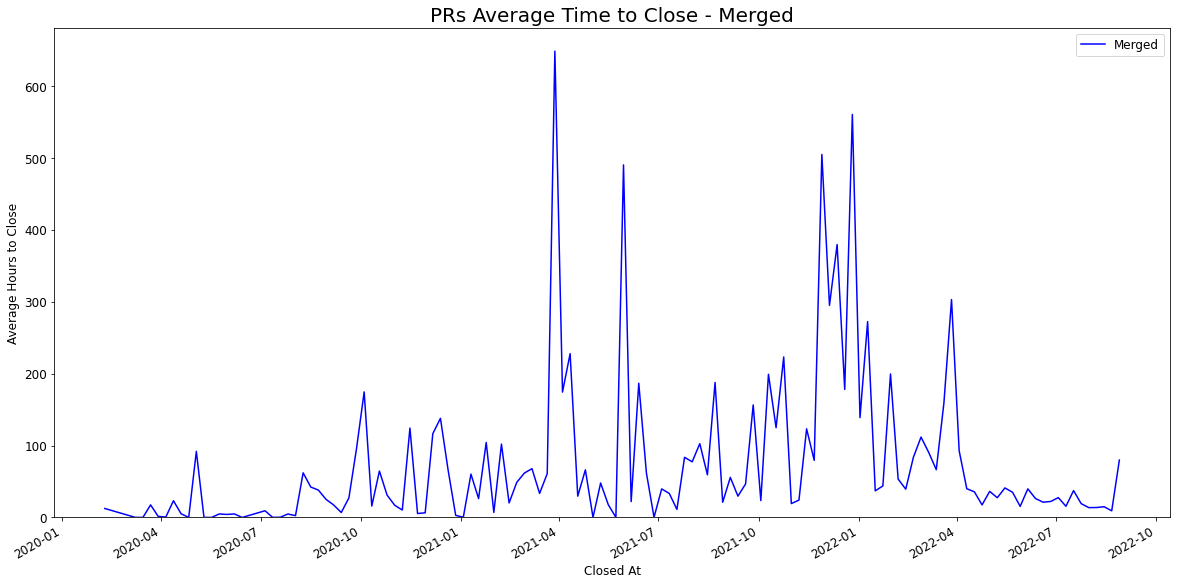

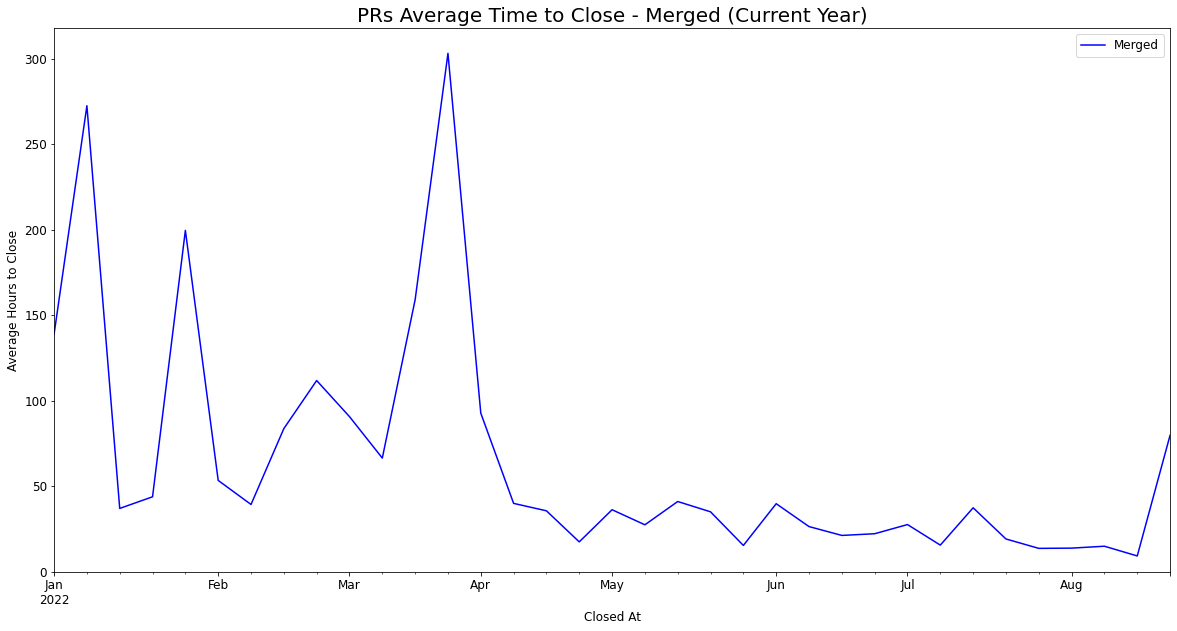

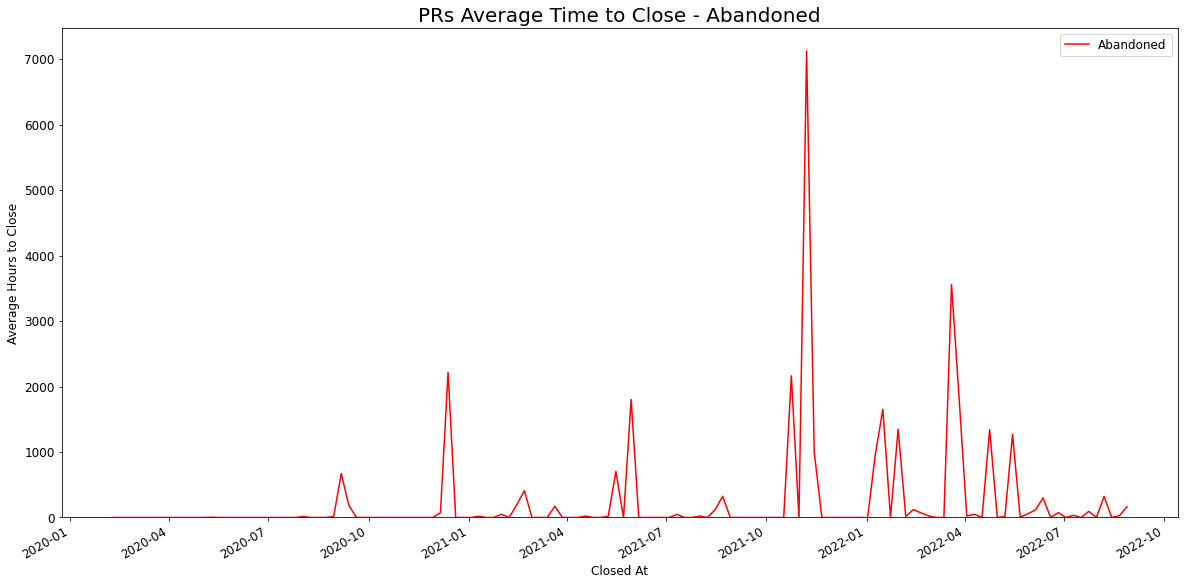

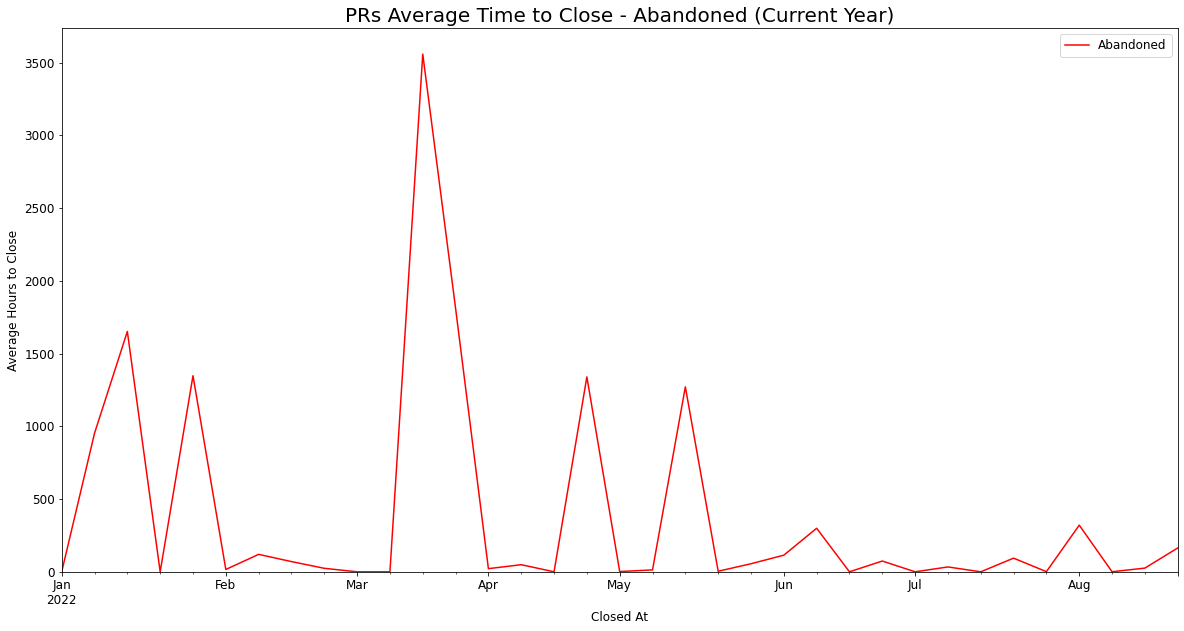

In [6]:
weekly_prs = prs.set_index('closedAt').groupby(
    [pd.Grouper(freq='W', label='left'), pd.Grouper('state')])['hoursToClose'].mean().reset_index(name='avgHoursToClose')

weekly_prs_pivot = weekly_prs.pivot('closedAt', 'state', 'avgHoursToClose')
weekly_prs_pivot = weekly_prs_pivot.fillna(0)

plot_line(weekly_prs_pivot, 'PRs Average Time to Close - Merged', 'Closed At', 'Average Hours to Close', [
          {'col': 'MERGED', 'color': 'blue', 'label': 'Merged'}])

# Filter to current year
weekly_prs_year = weekly_prs[weekly_prs['closedAt'].dt.year == date.today(
).year]
weekly_prs_pivot_year = pivot_with_zeros(
    weekly_prs_year, 'closedAt', 'state', 'avgHoursToClose')

plot_line(weekly_prs_pivot_year, 'PRs Average Time to Close - Merged (Current Year)', 'Closed At', 'Average Hours to Close', [
          {'col': 'MERGED', 'color': 'blue', 'label': 'Merged'}])

plot_line(weekly_prs_pivot, 'PRs Average Time to Close - Abandoned', 'Closed At', 'Average Hours to Close', [
          {'col': 'CLOSED', 'color': 'red', 'label': 'Abandoned'}])

plot_line(weekly_prs_pivot_year, 'PRs Average Time to Close - Abandoned (Current Year)', 'Closed At', 'Average Hours to Close', [
          {'col': 'CLOSED', 'color': 'red', 'label': 'Abandoned'}])


## Issues Over Time

### Total Issues Over Time

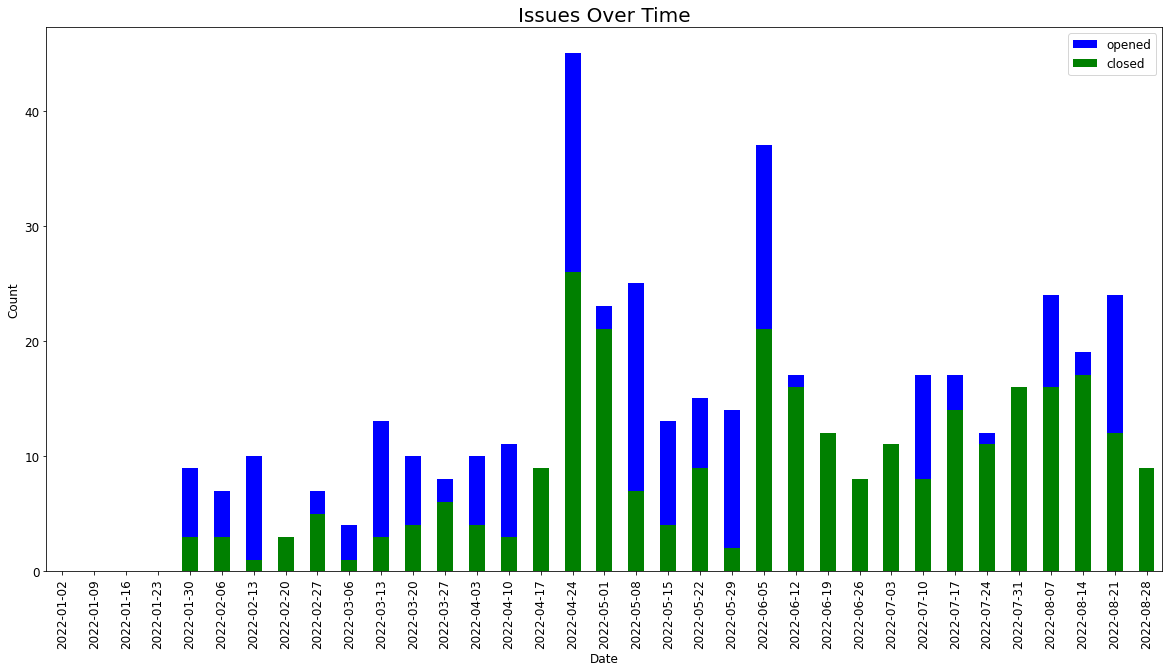

In [7]:
weekly_closed_issues = issues.set_index('closedAt').groupby(
    pd.Grouper(freq='W', label='left'))['state'].count().reset_index(name='closed')

weekly_closed_issues.rename(columns={'closedAt': 'date'}, inplace=True)

weekly_created_issues = issues.set_index('createdAt').groupby(
    pd.Grouper(freq='W', label='left'))['state'].count().reset_index(name='opened')

weekly_created_issues.rename(columns={'createdAt': 'date'}, inplace=True)

weekly_issues = weekly_closed_issues.merge(
    weekly_created_issues, how='outer', on='date').set_index('date').sort_index()

# Replace NaN
weekly_issues = weekly_issues.fillna(0)

# Filter to current year
weekly_issues = weekly_issues[weekly_issues.index.year == date.today().year]

# Only keep date
weekly_issues.index = weekly_issues.index.date

plot_bar(weekly_issues, 'Issues Over Time', 'Date', 'Count', [
         {'col': 'opened', 'color': 'blue'}, {'col': 'closed', 'color': 'green'}])


### Average Duration of Issues

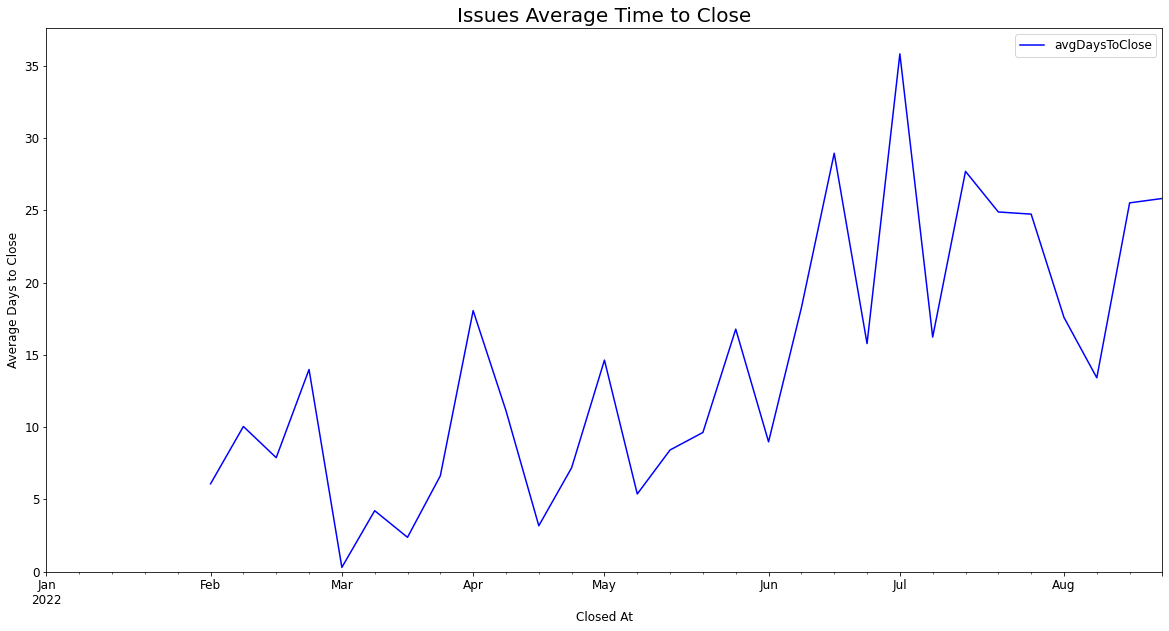

In [8]:
weekly_closed_issues = issues.set_index('closedAt').groupby(
    pd.Grouper(freq='W', label='left'))['daysToClose'].mean().reset_index(name='avgDaysToClose')

# Set index
weekly_closed_issues.index = weekly_closed_issues['closedAt']

# Clear first value to fix axis
weekly_closed_issues.at['2022-01-30', 'avgDaysToClose'] = np.nan

# Filter to current year
weekly_closed_issues = weekly_closed_issues[weekly_closed_issues.index.year == date.today(
).year]

plot_line(weekly_closed_issues, 'Issues Average Time to Close', 'Closed At', 'Average Days to Close', [
    {'col': 'avgDaysToClose', 'color': 'blue', 'label': None}])


### Bugs Opened & Closed Over Time

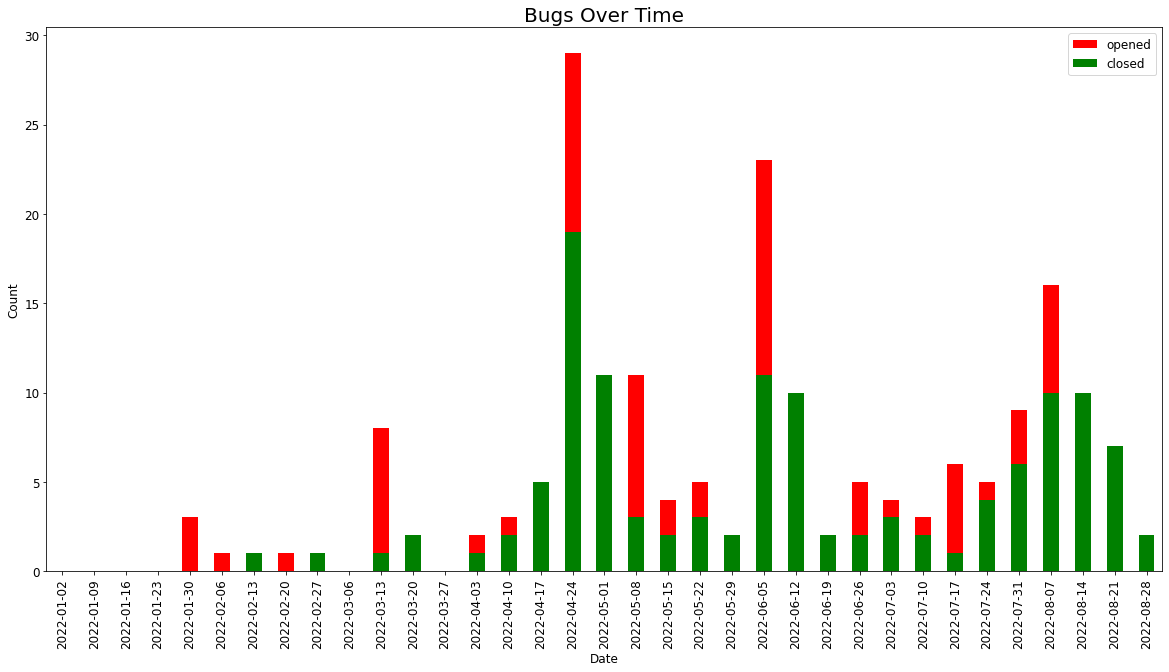

In [9]:
bugs = issues[issues['labels'].str.contains('bug')]

weekly_closed_bugs = bugs.set_index('closedAt').groupby(
    pd.Grouper(freq='W', label='left'))['state'].count().reset_index(name='closed')

weekly_closed_bugs.rename(columns={'closedAt': 'date'}, inplace=True)

weekly_created_bugs = bugs.set_index('createdAt').groupby(
    pd.Grouper(freq='W', label='left'))['state'].count().reset_index(name='opened')

weekly_created_bugs.rename(columns={'createdAt': 'date'}, inplace=True)

weekly_bugs = weekly_closed_bugs.merge(
    weekly_created_bugs, how='outer', on='date').set_index('date').sort_index()

# Replace NaN
weekly_bugs = weekly_bugs.fillna(0)

# Filter to current year
weekly_bugs = weekly_bugs[weekly_bugs.index.year == date.today().year]

# Only keep date
weekly_bugs.index = weekly_bugs.index.date

plot_bar(weekly_bugs, 'Bugs Over Time', 'Date', 'Count', [
         {'col': 'opened', 'color': 'red'}, {'col': 'closed', 'color': 'green'}])


### Enhancements Opened & Closed Over Time

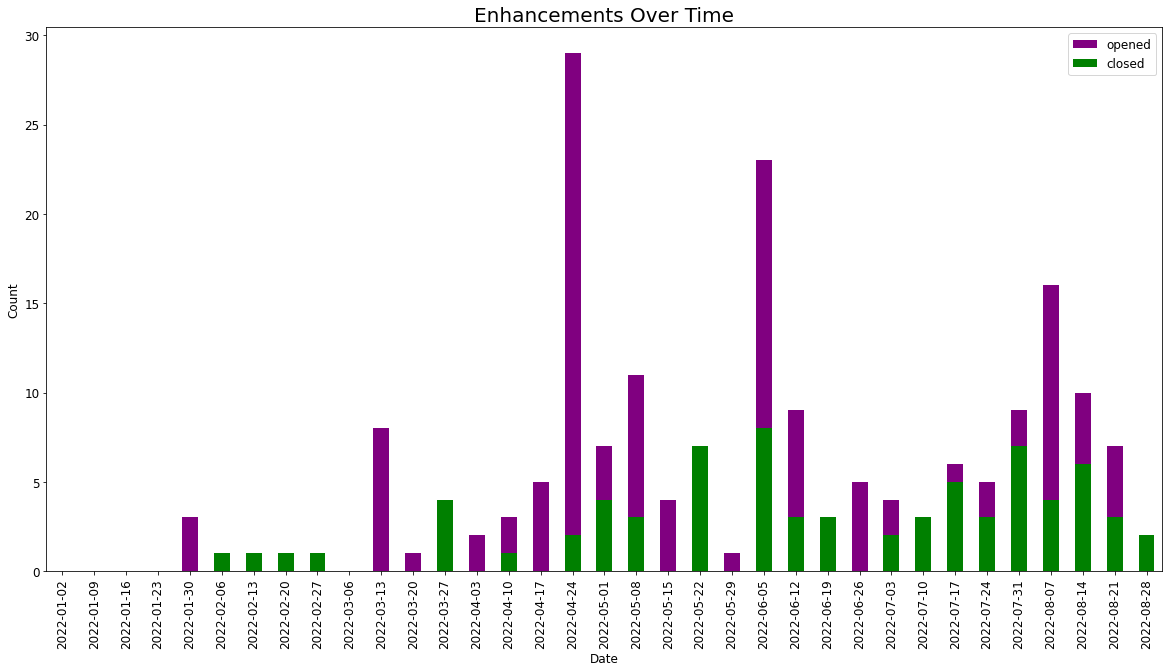

In [10]:
enhancements = issues[issues['labels'].str.contains('enhancement')]

weekly_closed_enhancements = enhancements.set_index('closedAt').groupby(
    pd.Grouper(freq='W', label='left'))['state'].count().reset_index(name='closed')

weekly_closed_enhancements.rename(columns={'closedAt': 'date'}, inplace=True)

weekly_created_enhancements = enhancements.set_index('createdAt').groupby(
    pd.Grouper(freq='W', label='left'))['state'].count().reset_index(name='opened')

weekly_created_enhancements.rename(columns={'createdAt': 'date'}, inplace=True)

weekly_enhancements = weekly_closed_enhancements.merge(
    weekly_created_bugs, how='outer', on='date').set_index('date').sort_index()

# Replace NaN
weekly_enhancements = weekly_enhancements.fillna(0)

# Filter to current year
weekly_enhancements = weekly_enhancements[weekly_enhancements.index.year == date.today(
).year]

# Only keep date
weekly_enhancements.index = weekly_enhancements.index.date

plot_bar(weekly_enhancements, 'Enhancements Over Time', 'Date', 'Count', [
         {'col': 'opened', 'color': 'purple'}, {'col': 'closed', 'color': 'green'}])
